In [1]:
import time
import cv2
import math

import numpy as np

from swarm import Swarm

from scipy.spatial import distance

In [2]:
NUM_DRONES = 5

AREA_SIZE_X = 100
AREA_SIZE_Y = 100
GRID_SIZE = 100           # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

MOVE_DISTANCE = 1       # How far a Drone can move each Timestep
DRONE_HEIGHT = 35

POPULATION_SIZE = 10
NUM_GENERATIONS = 2
MUTATION_RATE = 0.1

INITIAL_VISIBILITY =0.5

In [3]:
grid_offset=GRID_SIZE/2

camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)

prob_array_size= int(np.ceil((GRID_SIZE*512)/(camera_offset*2)))

In [4]:
ShouldPrint=False

In [5]:
def getProbabilityGrid(Last_Known_Position, sigma):
    #Create Target Probability Grid
    x = np.linspace(-grid_offset, grid_offset, prob_array_size)
    y = np.linspace(-grid_offset, grid_offset, prob_array_size)
    x, y = np.meshgrid(x, y)

    prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))

    return prob_density,x,y

In [6]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 
def update_Target_Position():
    if Target_Position[0]<25:
        Target_Position = Target_Position + [0.5,0.5]

Initialization of Drones and Solution Populations

In [7]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm("rhea_swarm")

# Spawn X drones and keep the returning ids as handles
ids = swarm.spawn(NUM_DRONES)

#Initialize Target Position
Target_Position =np.array([20,15])
Last_Known_Position = Target_Position

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
swarm.waypoints(ids, waypoints)

#Visibility by Coordiantes File:
grid_visibility = np.full((AREA_SIZE_X,AREA_SIZE_Y), INITIAL_VISIBILITY)

#Create Target Probability Grid
sigma= 10

prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)

#print(prob_density)


Subscribed successfully


In [8]:
#Create "Base Grid"
#by Calculating distance between each scanning point at DRONE_HEIGHT

#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)


    return array_width,array_height
def getOverlapArray(waypoints,img_width=512,img_height=512):
    
    global targetSeen
    global lastSeenAt
    targetSeen = False
    #TODO change MinX to value instead of array,its probably not needed 
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))

    #fills the array with zeroes
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    #adds 1/NUM_DRONES if the point is seen
    for id in range(len(waypoints)):
        for i in range(img_width):
            for j in range(img_height):
                if swarm.depth_images[id][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                    world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES
                    
                        #if a seen ground Tile is within 0.3 meters of the real target, it counts as seen
                        #
                        if (distance.euclidean([world_x,world_y], Target_Position)<=0.3):
                            targetSeen = True
                            lastSeenAt = [world_x,world_y]
                            #print([world_x,world_y],Target_Position)
    
    
    #gets the corner of the visibility array, so correct overlap with probability array can be calculated

    visibility_offset_x=int(((MinX[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    visibility_offset_y=int(((MinY[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    
    visibility_offset=[visibility_offset_x,visibility_offset_y]
    return visibility_array, visibility_offset
    


In [9]:
#print(swarm.depth_images[1])
#print(check_ground_visibility(swarm.depth_images[1]))


In [10]:
# Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.optimize import minimize

# Algorithmss
from pymoo.algorithms.soo.nonconvex.de import DE

# Survival operators
from pymoo.operators.sampling.lhs import LHS

In [11]:
global lastSeenAt
global targetSeen
lastSeenAt = [0,0]
targetSeen = False

In [12]:
def scoreThatThing(prob_density,visibility_grid,visibility_offset):
    
    #scoring_array=np.array(prob_density)
    if ShouldPrint:
        print(f"Prob_density {prob_density},\n\n visibility_grid: {visibility_grid},\n\n offset: {visibility_offset}")
        print(f"Prob_size: {np.shape(prob_density)}")
    scoring_array=np.zeros(prob_density.shape)
    score=0
    
    #print("Visibility grid in scoring: ", visibility_grid.shape)
    
    for i in range(visibility_grid.shape[0]):
        for j in range(visibility_grid.shape[1]):
            scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]=prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_grid[i][j]
            
            #only add score if half the drones see square
            if visibility_grid[i][j]>=0.5:
                score+=scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]
                
    #plt.imshow(scoring_array, cmap='gray')
    #plt.show()
    return score

In [13]:
class MyProblem(ElementwiseProblem):

    def __init__(self, grid_size, n_drones, n_steps,waypoints,prob_density):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        self.n_steps = n_steps
        
        self.waypoints = waypoints
        self.prob_density = prob_density
        
        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=1,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=0,      # Lower boundaries of solution variables
            xu=1,       # Upper bounds of solution vars
        )    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        
        #scales the variables to  [-2,2]
        _x= np.array(x)*4-2
        #reshapes the variables back into a waypoint array
        coordinates = _x.reshape(-1, 2)        
        
        #send drones to solution it wants to score
        tempWaypoints = waypoints + np.pad(coordinates,((0, 0), (0, 1)),mode='constant',constant_values=0)
        swarm.waypoints(ids,tempWaypoints)
        
        isScored = False
        score = None
        
        while not isScored:
            #wait until all drones received
            if swarm.received_frames[ids[-1]]:
                if ShouldPrint:
                    print("All Frames received")
                visibility_grid,visibility_offset = getOverlapArray(tempWaypoints)
                score = scoreThatThing(self.prob_density,visibility_grid,visibility_offset)
                
                if targetSeen:
                    score = score *2
                    print("A solution saw the target!")
                    print(lastSeenAt)
                    
                isScored=True
        
        if ShouldPrint:
            print("Score is:", -score, " for solution \n",tempWaypoints)
            
        out["F"] = -score

In [14]:
from pymoo.core.sampling import Sampling
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = [np.random.rand(problem.n_var)]
        #X = np.array(0)
        for i in range(n_samples-1):
            X= np.append(X,[np.random.rand(problem.n_var)], axis=0)
            #print(f"Sampled X: {X.shape} -> {X}") 
        #print(X)
        return X
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", NUM_GENERATIONS)

In [15]:
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, waypoints, prob_density)

algorithm = DE(
    pop_size=POPULATION_SIZE,
    sampling=MySampling(),    #Für initiale Population
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector"
)

In [16]:
import matplotlib.pyplot as plt


Starting Run number 0
Swarm is currently at [[-2.  0. 35.]
 [-1.  0. 35.]
 [ 0.  0. 35.]
 [ 1.  0. 35.]
 [ 2.  0. 35.]]
A solution saw the target!
[20.035394059249825, 14.945657193696698]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.941106E+02 | -7.115038E+02
A solution saw the target!
[19.9984673896169, 14.70466391594983]
A solution saw the target!
[20.035394059249825, 14.945657193696698]
     2 |       20 | -4.746178E+02 | -7.543292E+02
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[-4.66775635e-01 -3.43776049e-01  3.50000000e+01]
 [ 3.76973611e-03 -3.43282922e-01  3.50000000e+01]
 [-1.80018616e+00  1.43585624e-01  3.50000000e+01]
 [ 1.65517858e+00  5.95564482e-02  3.50000000e+01]
 [ 3.77837902e+00  3.46220162e-01  3.50000000e+01]]


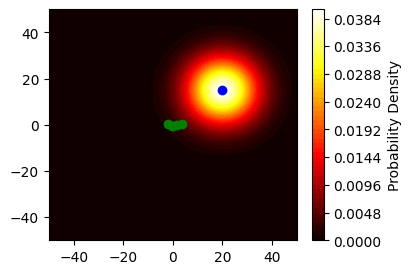

Starting Run number 1
Swarm is currently at [[-4.66775635e-01 -3.43776049e-01  3.50000000e+01]
 [ 3.76973611e-03 -3.43282922e-01  3.50000000e+01]
 [-1.80018616e+00  1.43585624e-01  3.50000000e+01]
 [ 1.65517858e+00  5.95564482e-02  3.50000000e+01]
 [ 3.77837902e+00  3.46220162e-01  3.50000000e+01]]
A solution saw the target!
[19.94634520589431, 14.788395631704741]
A solution saw the target!
[20.28370107989199, 14.909359354874397]
A solution saw the target!
[19.827335469165252, 15.212119133714717]
A solution saw the target!
[19.987877049001455, 14.794910073149397]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.490385E+02 | -8.564549E+02
A solution saw the target!
[20.201357206447828, 15.213858089520475]
A solution saw the target!
[20.108586038440052, 15.029708272786827]
A solution saw the target!
[19.763582469026872, 15.130542536006944]
A solution saw the target!
[20.28370107989199, 14.909359354874397]
     2 |       20 | -5.911294E+02 | -8.807853E+02
Best Solu

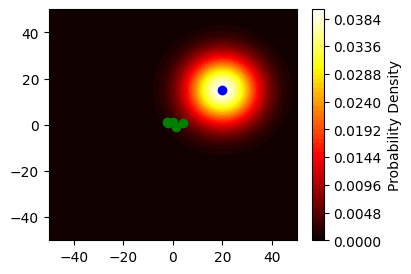

Starting Run number 2
Swarm is currently at [[-1.76246313  0.74350944 35.        ]
 [ 1.23906513 -0.99335849 35.        ]
 [-2.42000637  1.36875721 35.        ]
 [ 0.23669222  1.27559733 35.        ]
 [ 3.915324    0.74903624 35.        ]]
A solution saw the target!
[20.147043185361294, 15.063705711210005]
A solution saw the target!
[19.773021448078723, 14.977405212112952]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.597052E+02 | -9.336666E+02
A solution saw the target!
[19.990519017215142, 14.794994351185062]
     2 |       20 | -6.300817E+02 | -1.024548E+03
Best Solution: 
 [[-1.2956875   1.08728549]
 [ 1.2352954  -0.65007557]
 [-0.6198202   1.22517159]
 [-1.41848636  1.21604088]
 [ 0.13694498  0.40281608]]
Sending swarm to 
 [[-3.05815063  1.83079493 35.        ]
 [ 2.47436053 -1.64343406 35.        ]
 [-3.03982657  2.5939288  35.        ]
 [-1.18179414  2.4916382  35.        ]
 [ 4.05226898  1.15185232 35.        ]]


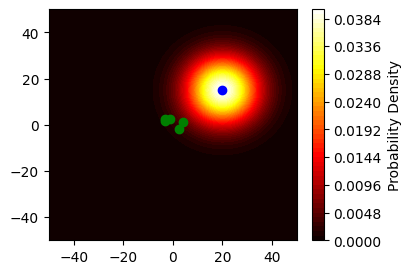

Starting Run number 3
Swarm is currently at [[-3.05815063  1.83079493 35.        ]
 [ 2.47436053 -1.64343406 35.        ]
 [-3.03982657  2.5939288  35.        ]
 [-1.18179414  2.4916382  35.        ]
 [ 4.05226898  1.15185232 35.        ]]
A solution saw the target!
[19.70509491441458, 15.014014287336868]
A solution saw the target!
[19.965223163998004, 15.020250790023377]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.271378E+02 | -1.018852E+03
A solution saw the target!
[19.901470163859624, 14.808183246455323]
A solution saw the target!
[20.191216996682122, 15.070304430690326]
     2 |       20 | -7.182600E+02 | -1.160764E+03
Best Solution: 
 [[-1.2956875   1.08728549]
 [ 1.2352954  -0.65007557]
 [-0.6198202   1.22517159]
 [-1.41848636  1.21604088]
 [ 0.13694498  0.40281608]]
Sending swarm to 
 [[-4.35383813  2.91808041 35.        ]
 [ 3.70965592 -2.29350963 35.        ]
 [-3.65964677  3.81910038 35.        ]
 [-2.6002805   3.70767908 35.        ]
 [ 4.189213

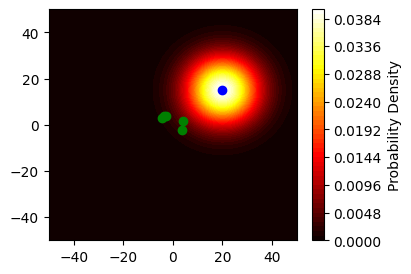

Starting Run number 4
Swarm is currently at [[-4.35383813  2.91808041 35.        ]
 [ 3.70965592 -2.29350963 35.        ]
 [-3.65964677  3.81910038 35.        ]
 [-2.6002805   3.70767908 35.        ]
 [ 4.18921396  1.5546684  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.769797E+02 | -6.076624E+02
     2 |       20 | -5.935926E+02 | -6.282148E+02
Best Solution: 
 [[ 1.95544436 -0.14418211]
 [-1.54225842  1.92355945]
 [-0.77773482 -0.50386503]
 [ 1.63438201 -0.30003509]
 [-1.99294922 -0.76137662]]
Sending swarm to 
 [[-2.39839378  2.77389831 35.        ]
 [ 2.16739751 -0.36995018 35.        ]
 [-4.43738159  3.31523536 35.        ]
 [-0.96589849  3.40764399 35.        ]
 [ 2.19626474  0.79329178 35.        ]]


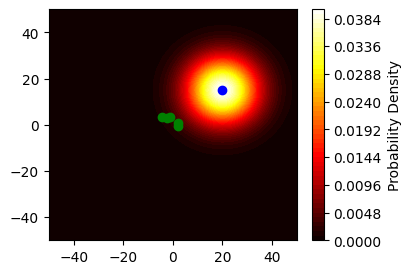

Starting Run number 5
Swarm is currently at [[-2.39839378  2.77389831 35.        ]
 [ 2.16739751 -0.36995018 35.        ]
 [-4.43738159  3.31523536 35.        ]
 [-0.96589849  3.40764399 35.        ]
 [ 2.19626474  0.79329178 35.        ]]
A solution saw the target!
[20.04039980324616, 14.782653972829639]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.893077E+02 | -1.182208E+03
A solution saw the target!
[19.748461133059717, 15.051684696189799]
A solution saw the target!
[20.04039980324616, 14.782653972829639]
     2 |       20 | -8.274121E+02 | -1.217534E+03
Best Solution: 
 [[-0.33191198 -0.62537188]
 [-1.68568441  0.37318555]
 [-1.05026531 -1.96036943]
 [ 1.35040769 -1.83120356]
 [ 1.80520535  0.74275689]]
Sending swarm to 
 [[-2.73030576e+00  2.14852643e+00  3.50000000e+01]
 [ 4.81713098e-01  3.23537576e-03  3.50000000e+01]
 [-5.48764689e+00  1.35486592e+00  3.50000000e+01]
 [ 3.84509203e-01  1.57644043e+00  3.50000000e+01]
 [ 4.00147010e+00  1.53604867e+0

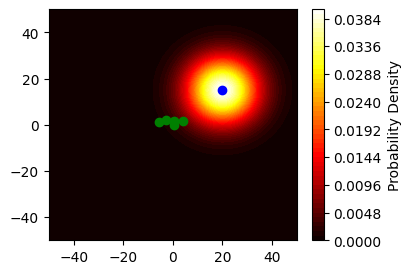

Starting Run number 6
Swarm is currently at [[-2.73030576e+00  2.14852643e+00  3.50000000e+01]
 [ 4.81713098e-01  3.23537576e-03  3.50000000e+01]
 [-5.48764689e+00  1.35486592e+00  3.50000000e+01]
 [ 3.84509203e-01  1.57644043e+00  3.50000000e+01]
 [ 4.00147010e+00  1.53604867e+00  3.50000000e+01]]
A solution saw the target!
[19.978177280396096, 15.213188134889736]
A solution saw the target!
[20.019709123503237, 14.900937575642498]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -7.194516E+02 | -1.278851E+03
A solution saw the target!
[19.978177280396096, 15.12862659159844]
A solution saw the target!
[20.012912112665077, 15.00822977500317]
A solution saw the target!
[19.986673543943795, 15.109064038223288]
     2 |       20 | -8.739743E+02 | -1.278851E+03
Best Solution: 
 [[ 1.53322436  0.49468883]
 [ 1.00376974 -0.60440663]
 [-0.92028843  1.58354487]
 [-0.28763524  1.85936019]
 [ 0.65376599  0.48678288]]
Sending swarm to 
 [[-1.19708139  2.64321526 35.        ]
 

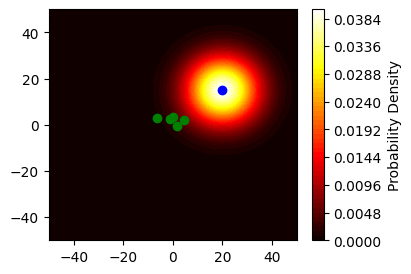

Starting Run number 7
Swarm is currently at [[-1.19708139  2.64321526 35.        ]
 [ 1.48548283 -0.60117126 35.        ]
 [-6.40793533  2.93841079 35.        ]
 [ 0.09687396  3.43580062 35.        ]
 [ 4.65523609  2.02283155 35.        ]]
A solution saw the target!
[19.999599479647557, 14.88737086729832]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.905428E+02 | -1.267100E+03
     2 |       20 | -7.147040E+02 | -1.267100E+03
Best Solution: 
 [[ 1.95544436  0.99266262]
 [-0.87822403  1.15711731]
 [-1.58709597 -0.2084259 ]
 [ 1.63438201 -0.82554341]
 [-0.84889865 -1.47988571]]
Sending swarm to 
 [[ 0.75836296  3.63587788 35.        ]
 [ 0.6072588   0.55594606 35.        ]
 [-7.9950313   2.7299849  35.        ]
 [ 1.73125598  2.61025721 35.        ]
 [ 3.80633744  0.54294584 35.        ]]


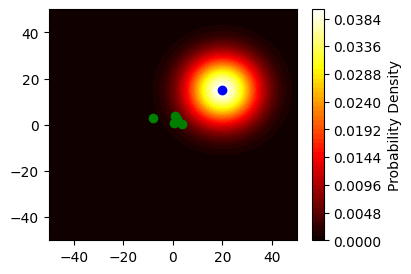

Starting Run number 8
Swarm is currently at [[ 0.75836296  3.63587788 35.        ]
 [ 0.6072588   0.55594606 35.        ]
 [-7.9950313   2.7299849  35.        ]
 [ 1.73125598  2.61025721 35.        ]
 [ 3.80633744  0.54294584 35.        ]]
A solution saw the target!
[19.85529388970136, 15.090079807177961]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.808312E+02 | -1.302947E+03
A solution saw the target!
[20.10180962670718, 14.900559762568582]
A solution saw the target!
[20.07279145883778, 14.90766894625007]
A solution saw the target!
[19.727787889424604, 14.944750209331808]
A solution saw the target!
[19.744731604628342, 14.947416835029895]
     2 |       20 | -8.837507E+02 | -1.302947E+03
Best Solution: 
 [[ 1.61360766 -1.45010118]
 [-1.44289461  1.22956515]
 [-0.40929265 -1.33858321]
 [ 1.71003432 -0.60893656]
 [ 1.00324841  0.90399194]]
Sending swarm to 
 [[ 2.37197062  2.18577669 35.        ]
 [-0.83563581  1.78551121 35.        ]
 [-8.40432395  1.3914016

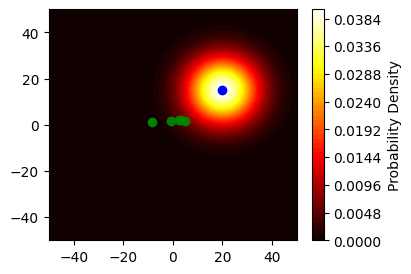

Starting Run number 9
Swarm is currently at [[ 2.37197062  2.18577669 35.        ]
 [-0.83563581  1.78551121 35.        ]
 [-8.40432395  1.39140169 35.        ]
 [ 3.4412903   2.00132065 35.        ]
 [ 4.80958586  1.44693778 35.        ]]
A solution saw the target!
[19.95238778773107, 14.735322742084357]
A solution saw the target!
[19.74592257058883, 14.945071817297766]
A solution saw the target!
[20.06179104183032, 15.134128365035329]
A solution saw the target!
[19.898937245984058, 15.204019099110539]
A solution saw the target!
[19.994775753902307, 14.80515398232747]
A solution saw the target!
[20.03471891212152, 14.93898312803151]
A solution saw the target!
[20.051334320144125, 15.016347539781709]
A solution saw the target!
[20.162210024230966, 15.239806547682967]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.840024E-01 | -1.047144E+00
A solution saw the target!
[19.77365301974419, 15.152072129205447]
A solution saw the target!
[19.74592257058883, 14.94507

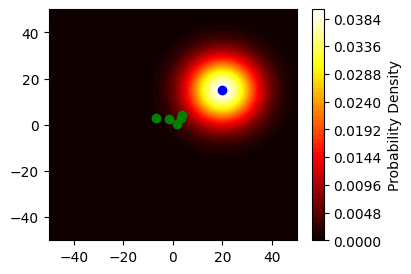

Starting Run number 10
Swarm is currently at [[ 3.5749489   4.058823   35.        ]
 [-1.5819391   2.55480167 35.        ]
 [-6.89876734  2.96982834 35.        ]
 [ 1.78146714  0.15753978 35.        ]
 [ 3.48890754  2.95950779 35.        ]]
A solution saw the target!
[20.14240020687472, 15.2398073181584]
A solution saw the target!
[20.193583286276386, 15.18821263459909]
A solution saw the target!
[19.720626717371697, 15.106575255997704]
A solution saw the target!
[19.856628981196152, 14.95652175676227]
A solution saw the target!
[20.01717056103235, 15.11308969744236]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.815564E+00 | -1.351307E+01
A solution saw the target!
[20.03939171806359, 15.213272713121544]
A solution saw the target!
[19.81911454977906, 15.22038189680303]
A solution saw the target!
[19.92038198133453, 15.25746315988477]
     2 |       20 | -2.581143E+00 | -1.351307E+01
Best Solution: 
 [[ 1.20297827  1.8730463 ]
 [-0.74630329  0.76929046]
 [ 1.5

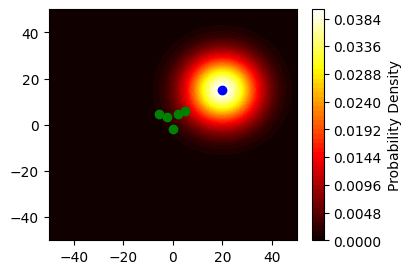

Starting Run number 11
Swarm is currently at [[ 4.77792717  5.9318693  35.        ]
 [-2.32824238  3.32409214 35.        ]
 [-5.39321073  4.548255   35.        ]
 [ 0.12164399 -1.68624108 35.        ]
 [ 2.16822921  4.47207781 35.        ]]
A solution saw the target!
[20.065500226238527, 15.292316290128108]
A solution saw the target!
[20.07419026504141, 15.215649318084893]
A solution saw the target!
[19.94281247853253, 15.264016617023007]
A solution saw the target!
[20.057748558072575, 15.276174933602077]
A solution saw the target!
[20.22593586470516, 15.128519137649302]
A solution saw the target!
[20.081799568238488, 15.288225145412184]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.878895E+01 | -2.740354E+02
A solution saw the target!
[19.866489557657438, 15.223131212267536]
A solution saw the target!
[19.832486565184162, 15.22560233174683]
A solution saw the target!
[20.01804656810011, 15.278549270266945]
A solution saw the target!
[19.968492939738134, 15.2

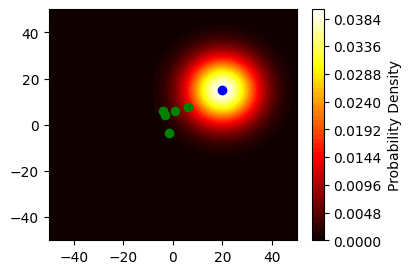

Starting Run number 12
Swarm is currently at [[ 5.98090545  7.8049156  35.        ]
 [-3.07454567  4.0933826  35.        ]
 [-3.88765412  6.12668165 35.        ]
 [-1.53817917 -3.53002195 35.        ]
 [ 0.84755089  5.98464782 35.        ]]
A solution saw the target!
[19.9934184981731, 15.252772588854336]
A solution saw the target!
[20.129614537252742, 15.239858616949501]
A solution saw the target!
[19.934483750605484, 15.224472915749235]
A solution saw the target!
[19.930024817324203, 15.26721211773511]
A solution saw the target!
[20.176925830422284, 15.236631232328303]
A solution saw the target!
[20.187882314718596, 15.214322747122026]
A solution saw the target!
[20.13723419771844, 15.239005568993173]
A solution saw the target!
[20.00971784017306, 15.248681444138413]
A solution saw the target!
[20.059374373943882, 15.276889647976688]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.175814E+02 | -3.365359E+02
A solution saw the target!
[20.184677498588236, 15.2

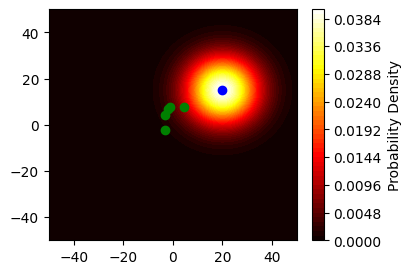

Starting Run number 13
Swarm is currently at [[ 4.38671535  7.4893461  35.        ]
 [-3.27855091  4.18782598 35.        ]
 [-2.1317953   7.03033536 35.        ]
 [-3.21469347 -2.19151926 35.        ]
 [-1.079296    7.68246281 35.        ]]
A solution saw the target!
[20.05680640542311, 15.19221508942806]
A solution saw the target!
[20.065496444225992, 15.243054117661604]
A solution saw the target!
[20.061624657993875, 15.291421416599716]
A solution saw the target!
[19.98530173711878, 15.239826733040406]
A solution saw the target!
[20.089736043612987, 15.283429937502769]
A solution saw the target!
[20.13685874756145, 15.251876944850515]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.674175E+02 | -4.001463E+02
A solution saw the target!
[19.801794404869597, 15.215617240956952]
A solution saw the target!
[20.240313737672295, 15.05927701142911]
A solution saw the target!
[20.14255774506064, 15.25300713132354]
A solution saw the target!
[20.017089464221353, 15.263

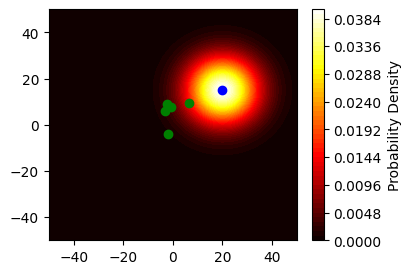

Starting Run number 14
Swarm is currently at [[ 6.37190972  9.45148412 35.        ]
 [-3.12779942  6.10164906 35.        ]
 [-2.16550266  8.82530522 35.        ]
 [-1.88840707 -4.1802755  35.        ]
 [-0.72207385  7.88691071 35.        ]]
A solution saw the target!
[20.129410764562827, 15.24176310315487]
A solution saw the target!
[20.010594803088956, 15.292602131388414]
A solution saw the target!
[20.07047601699521, 15.277216430188147]
A solution saw the target!
[20.00226408357555, 15.256202632035643]
A solution saw the target!
[20.0579060962585, 15.289374746767217]
A solution saw the target!
[20.13261558069319, 15.267066261560938]
A solution saw the target!
[20.018214463554653, 15.291749083432085]
A solution saw the target!
[20.145710106562788, 15.237671958438947]
A solution saw the target!
[20.13161364019523, 15.26588016227722]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.022041E+02 | -5.751228E+02
A solution saw the target!
[20.129410764562827, 15.2651

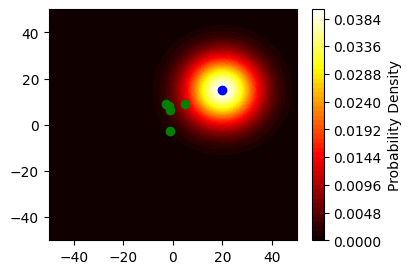

Starting Run number 15
Swarm is currently at [[ 4.76529705  9.13591462 35.        ]
 [-1.2962413   6.2343102  35.        ]
 [-1.3979942   8.08736774 35.        ]
 [-1.14240336 -2.84177281 35.        ]
 [-2.64892074  8.88748797 35.        ]]
A solution saw the target!
[20.1166231033545, 15.244958603866973]
A solution saw the target!
[19.99780714188062, 15.295797632100516]
A solution saw the target!
[20.05768835578688, 15.28041193090025]
A solution saw the target!
[20.045118435050167, 15.29257024747932]
A solution saw the target!
[20.022046741267616, 15.144914451526546]
A solution saw the target!
[20.132922445354456, 15.24086745915105]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.203680E+02 | -5.084432E+02
A solution saw the target!
[20.05287010321612, 15.268360755395864]
A solution saw the target!
[20.172624435326924, 15.239526526144779]
A solution saw the target!
[20.138621442853648, 15.241997645624075]
A solution saw the target!
[20.013153162014362, 15.2529

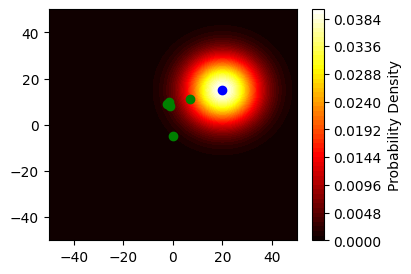

Starting Run number 16
Swarm is currently at [[ 6.75049141 11.09805264 35.        ]
 [-1.14548981  8.14813328 35.        ]
 [-1.43170157  9.88233761 35.        ]
 [ 0.18388304 -4.83052906 35.        ]
 [-2.29169859  9.09193586 35.        ]]
A solution saw the target!
[19.99796846207908, 15.294506617593782]
A solution saw the target!
[20.070411501020338, 15.281592645688946]
A solution saw the target!
[20.06653971478822, 15.202453944350303]
A solution saw the target!
[20.125833781645312, 15.245193146336177]
A solution saw the target!
[20.117722794189884, 15.214612260929371]
A solution saw the target!
[20.128679278486196, 15.25605677586147]
A solution saw the target!
[20.078031161486038, 15.28073959773262]
A solution saw the target!
[20.094651100407333, 15.258215465391734]
A solution saw the target!
[19.95051480394066, 15.290415472877859]
A solution saw the target!
[19.87266533743472, 15.254870676577754]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.610438E+02 |

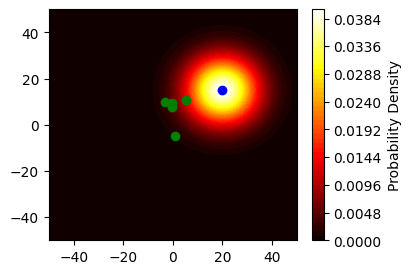

Starting Run number 17
Swarm is currently at [[ 5.15982913 10.75427659 35.        ]
 [-0.36788918  7.80485036 35.        ]
 [-3.23188773 10.02592323 35.        ]
 [ 0.83906162 -4.77097261 35.        ]
 [-0.51331957  9.43815602 35.        ]]
A solution saw the target!
[20.128637181126606, 15.269495569563949]
A solution saw the target!
[20.13732721992949, 15.256581597659114]
A solution saw the target!
[20.133455433697367, 15.241195896458848]
A solution saw the target!
[19.81023149972419, 15.220182098306342]
A solution saw the target!
[20.057132512822278, 15.253354213037918]
A solution saw the target!
[19.82618187970329, 15.191975549564408]
A solution saw the target!
[20.034060819039727, 15.29695741750028]
A solution saw the target!
[20.08118352298819, 15.265404424848025]
A solution saw the target!
[19.812075056067115, 15.22985962854792]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.623969E+02 | -6.900282E+02
A solution saw the target!
[20.06488418098823, 15.292

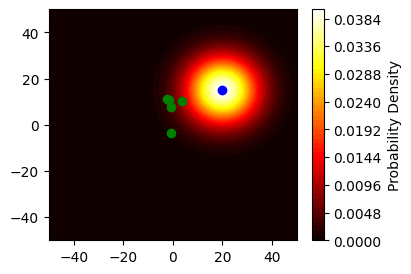

Starting Run number 18
Swarm is currently at [[ 3.56563903 10.43870709 35.        ]
 [-0.57189441  7.89929373 35.        ]
 [-1.4760289  10.92957694 35.        ]
 [-0.83745268 -3.43246992 35.        ]
 [-2.44016646 11.13597102 35.        ]]
A solution saw the target!
[20.133090340808998, 15.24439139717095]
A solution saw the target!
[20.12052042007229, 15.25654971375002]
A solution saw the target!
[20.097448726289738, 15.236399918074003]
A solution saw the target!
[20.08081843009982, 15.268599925560128]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.786271E+02 | -6.408361E+02
A solution saw the target!
[20.12052042007229, 15.267258992553858]
A solution saw the target!
[20.08651742759901, 15.269730112033152]
A solution saw the target!
[20.144571430238198, 15.258924050414889]
     2 |       20 | -4.523875E+02 | -7.024858E+02
Best Solution: 
 [[ 1.98519436  1.96213802]
 [ 0.15075149  1.91382308]
 [-0.03370736  1.79496986]
 [ 1.3262864  -1.98875624]
 [ 0.35722215 

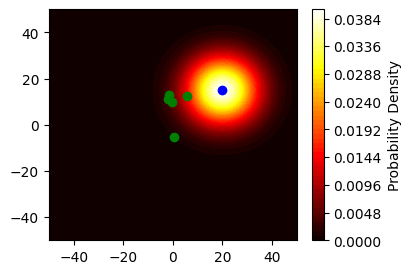

Starting Run number 19
Swarm is currently at [[ 5.5508334  12.40084511 35.        ]
 [-0.42114293  9.81311681 35.        ]
 [-1.50973627 12.7245468  35.        ]
 [ 0.48883372 -5.42122616 35.        ]
 [-2.08294431 11.34041891 35.        ]]
A solution saw the target!
[20.137123447239578, 15.258486083864481]
A solution saw the target!
[20.145813486042464, 15.245572111959646]
A solution saw the target!
[19.886929699256825, 15.23018641075938]
A solution saw the target!
[20.0099767662523, 15.272925612745254]
A solution saw the target!
[20.065618778935246, 15.24234472733845]
A solution saw the target!
[19.88531626281642, 15.22003624213217]
A solution saw the target!
[20.025927146231403, 15.244719064003318]
A solution saw the target!
[20.042547085152698, 15.285947931800813]
A solution saw the target!
[20.08966978910116, 15.254394939148558]
A solution saw the target!
[20.0755733227336, 15.218850142848453]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -8.563886E+02 | -1

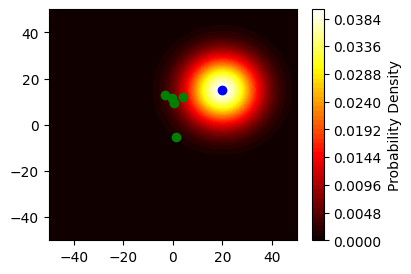

Starting Run number 20
Swarm is currently at [[ 3.96017111 12.05706906 35.        ]
 [ 0.35645771  9.46983389 35.        ]
 [-3.30992243 12.86813243 35.        ]
 [ 1.1440123  -5.36166971 35.        ]
 [-0.30456529 11.68663907 35.        ]]
A solution saw the target!
[19.88527416545683, 15.233475035834648]
A solution saw the target!
[19.83021120412134, 15.22056106392981]
A solution saw the target!
[20.20885741871949, 15.205175362729547]
A solution saw the target!
[20.06878149770602, 15.281086679446995]
A solution saw the target!
[20.10946280406185, 15.260936883770977]
A solution saw the target!
[20.029079507733552, 15.293136891257102]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.962888E+02 | -7.768417E+02
A solution saw the target!
[19.88527416545683, 15.25687718736354]
A solution saw the target!
[20.06878149770602, 15.291795958250832]
A solution saw the target!
[20.162284505509497, 15.230514077591748]
A solution saw the target!
[19.845557224255074, 15.24141

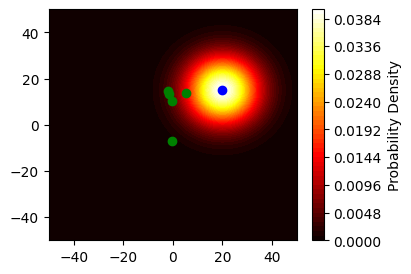

Starting Run number 21
Swarm is currently at [[ 5.16314939 13.93011536 35.        ]
 [-0.38984558 10.23912435 35.        ]
 [-1.80436582 14.44655908 35.        ]
 [-0.51581085 -7.20545058 35.        ]
 [-1.62524361 13.19920909 35.        ]]
A solution saw the target!
[20.1319574380833, 15.193931334560876]
A solution saw the target!
[20.140647476886183, 15.24477036279442]
A solution saw the target!
[20.136775690654062, 15.229384661594153]
A solution saw the target!
[19.813551756680884, 15.14461786330327]
A solution saw the target!
[20.18795877005573, 15.177789978034845]
A solution saw the target!
[19.829502136659986, 15.180164314699713]
A solution saw the target!
[20.03738107599642, 15.285146182635586]
A solution saw the target!
[19.893244779529745, 15.18984018984495]
A solution saw the target!
[19.815395313023807, 15.218048393683226]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -8.508657E+02 | -1.142933E+03
A solution saw the target!
[20.19571043822168, 15.2173

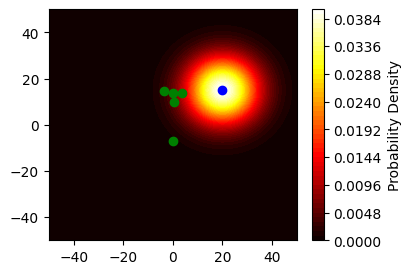

Starting Run number 22
Swarm is currently at [[ 3.5724871  13.58633931 35.        ]
 [ 0.38775505  9.89584143 35.        ]
 [-3.60455198 14.59014471 35.        ]
 [ 0.13936773 -7.14589413 35.        ]
 [ 0.15313541 13.54542925 35.        ]]
A solution saw the target!
[20.012432409148076, 15.076867613287563]
A solution saw the target!
[20.1911214888265, 15.21653193014339]
A solution saw the target!
[20.104296794905572, 15.26013513460575]
A solution saw the target!
[20.023913498577276, 15.292335142091877]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.924282E+02 | -8.247700E+02
A solution saw the target!
[19.936109488272983, 15.290994209085607]
A solution saw the target!
[20.093365496214844, 15.229712328426523]
A solution saw the target!
[19.89640749830052, 15.218906266808258]
     2 |       20 | -5.559043E+02 | -8.247700E+02
Best Solution: 
 [[ 1.20297827  1.8730463 ]
 [-0.74630329  0.76929046]
 [ 1.50555661  1.57842665]
 [-1.65982315 -1.84378087]
 [-1.32067832

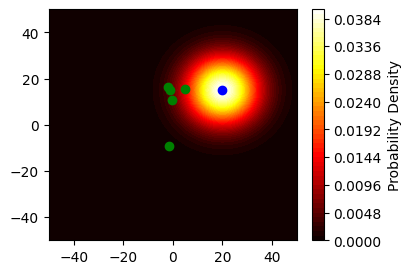

Starting Run number 23
Swarm is currently at [[ 4.77546538 15.45938561 35.        ]
 [-0.35854824 10.66513189 35.        ]
 [-2.09899538 16.16857136 35.        ]
 [-1.52045543 -8.989675   35.        ]
 [-1.16754291 15.05799926 35.        ]]
A solution saw the target!
[20.1905444290654, 15.065623585118892]
A solution saw the target!
[20.199234467868283, 15.116462613352436]
A solution saw the target!
[20.195362681636162, 15.164829912290548]
A solution saw the target!
[20.11903976076107, 15.240741229007996]
A solution saw the target!
[19.96846206670176, 15.284344433470359]
A solution saw the target!
[20.14309077092698, 15.252791440818106]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -7.554893E+02 | -1.132701E+03
A solution saw the target!
[20.063038428788644, 15.21653173692454]
A solution saw the target!
[20.11903976076107, 15.251450507811835]
A solution saw the target!
[20.085036768287793, 15.25392162729113]
A solution saw the target!
[20.023321487586884, 15.1373

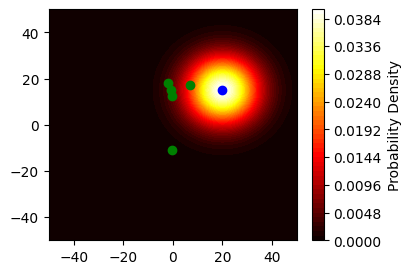

Starting Run number 24
Swarm is currently at [[  6.76065974  17.42152363  35.        ]
 [ -0.20779675  12.57895497  35.        ]
 [ -2.13270274  17.96354122  35.        ]
 [ -0.19416903 -10.97843124  35.        ]
 [ -0.81032076  15.26244716  35.        ]]
A solution saw the target!
[20.008136787651605, 14.860159598292189]
A solution saw the target!
[20.20808582686962, 15.166010627079245]
A solution saw the target!
[20.00849610694108, 14.747093126896203]
A solution saw the target!
[20.064138119624033, 15.290289242734808]
A solution saw the target!
[20.21570548733532, 14.973898578707782]
A solution saw the target!
[20.10481942597986, 15.27013944705879]
A solution saw the target!
[20.088189129789942, 15.238586454406537]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.325422E+02 | -8.824627E+02
A solution saw the target!
[20.13564278792836, 15.266079750651352]
A solution saw the target!
[20.020918675261047, 14.747093126896203]
A solution saw the target!
[20.1278911

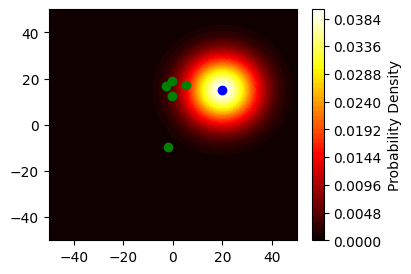

Starting Run number 25
Swarm is currently at [[ 5.16646964 17.10595413 35.        ]
 [-0.41180199 12.67339835 35.        ]
 [-0.37684391 18.86719493 35.        ]
 [-1.87068333 -9.63992855 35.        ]
 [-2.73716765 16.96026215 35.        ]]
A solution saw the target!
[20.016461733566118, 14.786688126961074]
A solution saw the target!
[20.063773026735664, 15.22973174330853]
A solution saw the target!
[19.83282239361668, 14.977094079419885]
A solution saw the target!
[19.976948332814732, 15.273334947770893]
A solution saw the target!
[20.087824036901573, 15.24178195511864]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.278768E+02 | -9.048915E+02
A solution saw the target!
[20.135277695039996, 15.01426325080994]
A solution saw the target!
[19.883022207043137, 15.116724152691258]
A solution saw the target!
[20.127526026874044, 15.240441022112371]
A solution saw the target!
[20.159313753976612, 15.062558636315641]
A solution saw the target!
[20.024071036763196, 15.

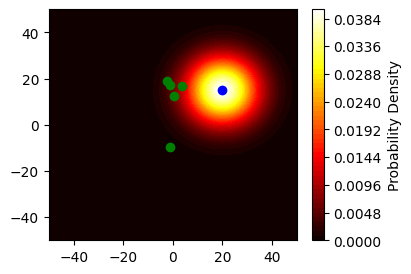

Starting Run number 26
Swarm is currently at [[ 3.57580736 16.76217808 35.        ]
 [ 0.36579865 12.33011543 35.        ]
 [-2.17703007 19.01078055 35.        ]
 [-1.21550475 -9.5803721  35.        ]
 [-0.95878863 17.30648231 35.        ]]
A solution saw the target!
[20.27076466665828, 14.873797378007737]
A solution saw the target!
[20.25819474592157, 15.077214695001942]
A solution saw the target!
[20.107617051862263, 15.248323899741061]
A solution saw the target!
[20.02723375553397, 14.706746905981777]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.332522E+02 | -9.437761E+02
A solution saw the target!
[20.25819474592157, 15.15167697394416]
A solution saw the target!
[20.224191753448295, 14.83538309273156]
A solution saw the target!
[20.02723375553397, 15.015836031528433]
     2 |       20 | -6.129603E+02 | -9.437761E+02
Best Solution: 
 [[ 1.20297827  1.8730463 ]
 [-0.74630329  0.76929046]
 [ 1.50555661  1.57842665]
 [-1.65982315 -1.84378087]
 [-1.32067832  

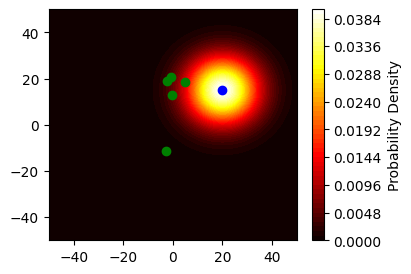

Starting Run number 27
Swarm is currently at [[  4.77878563  18.63522439  35.        ]
 [ -0.38050464  13.09940589  35.        ]
 [ -0.67147347  20.58920721  35.        ]
 [ -2.8753279  -11.42415297  35.        ]
 [ -2.27946695  18.81905233  35.        ]]
A solution saw the target!
[20.16304132407359, 15.20878019846729]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.962653E+02 | -1.186656E+03
A solution saw the target!
[19.707876743851685, 15.061756887150416]
A solution saw the target!
[20.082658027745296, 14.912539330116283]
     2 |       20 | -7.021455E+02 | -1.204254E+03
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  6.31201     18.29144834  35.        ]
 [  0.62326509  12.75612297  35.        ]
 [ -2.47165963  20.73279283  35.        ]
 [ -2.22014932 -11.36459652  35.        ]
 [ -0.50108793  19.16527249  35.        ]]


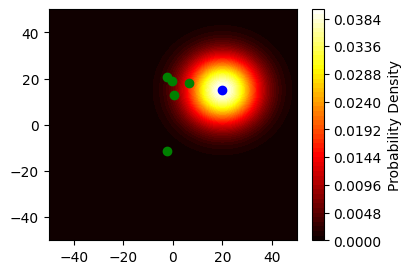

Starting Run number 28
Swarm is currently at [[  6.31201     18.29144834  35.        ]
 [  0.62326509  12.75612297  35.        ]
 [ -2.47165963  20.73279283  35.        ]
 [ -2.22014932 -11.36459652  35.        ]
 [ -0.50108793  19.16527249  35.        ]]
A solution saw the target!
[20.069870366536964, 14.72447583041325]
A solution saw the target!
[19.998006378943156, 14.757647945144823]
A solution saw the target!
[20.16619368557574, 15.247522150575836]
A solution saw the target!
[20.149563389385825, 15.088463157646826]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -8.741639E+02 | -1.301122E+03
A solution saw the target!
[20.133264047385865, 15.243462454168398]
A solution saw the target!
[20.08229293485693, 14.72447583041325]
A solution saw the target!
[20.061759379081536, 15.278381225055693]
A solution saw the target!
[20.221053106460865, 15.164251839397343]
A solution saw the target!
[19.95830438897069, 15.078787282501587]
A solution saw the target!
[20.100009

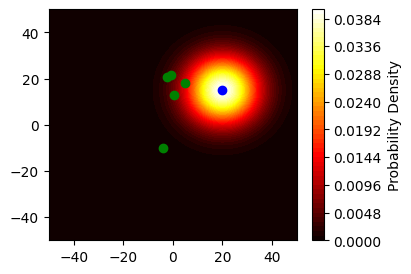

Starting Run number 29
Swarm is currently at [[  4.7178199   17.97587884  35.        ]
 [  0.41925986  12.85056635  35.        ]
 [ -0.7158008   21.63644654  35.        ]
 [ -3.89666362 -10.02609383  35.        ]
 [ -2.42793482  20.86308748  35.        ]]
A solution saw the target!
[20.102075592548992, 15.250717651287939]
A solution saw the target!
[20.212951296635836, 15.02790565822055]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.625665E+02 | -9.021782E+02
A solution saw the target!
[20.188900286469924, 15.090317725352659]
A solution saw the target!
[19.774417012603845, 15.103694339971067]
A solution saw the target!
[20.0216922962207, 15.273241783628826]
     2 |       20 | -5.444858E+02 | -9.021782E+02
Best Solution: 
 [[ 1.61360766 -1.45010118]
 [-1.44289461  1.22956515]
 [-0.40929265 -1.33858321]
 [ 1.71003432 -0.60893656]
 [ 1.00324841  0.90399194]]
Sending swarm to 
 [[  6.33142756  16.52577765  35.        ]
 [ -1.02363475  14.0801315   35.        ]
 

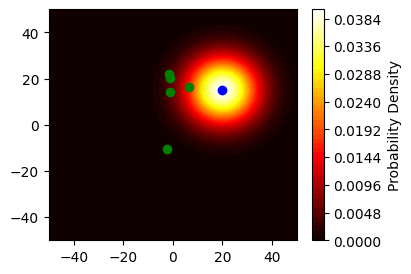

Starting Run number 30
Swarm is currently at [[  6.33142756  16.52577765  35.        ]
 [ -1.02363475  14.0801315   35.        ]
 [ -1.12509345  20.29786333  35.        ]
 [ -2.1866293  -10.63503039  35.        ]
 [ -1.4246864   21.76707942  35.        ]]
A solution saw the target!
[20.216434612327944, 15.17572062298089]
A solution saw the target!
[20.097618650854066, 15.226559651214433]
A solution saw the target!
[20.2212528648987, 15.147420949875789]
A solution saw the target!
[20.15304093147904, 15.062654151584905]
A solution saw the target!
[20.017423943746856, 15.287085266731616]
A solution saw the target!
[20.105238311319766, 15.225706603258107]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.912161E+02 | -1.227884E+03
A solution saw the target!
[20.088928612051184, 15.26287577464816]
A solution saw the target!
[20.088734294416405, 15.279673157988942]
A solution saw the target!
[20.15543812474622, 15.237830676252718]
A solution saw the target!
[20.1449299

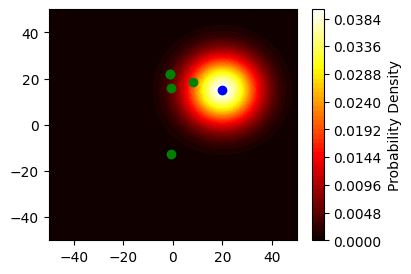

Starting Run number 31
Swarm is currently at [[  8.31662193  18.48791567  35.        ]
 [ -0.87288326  15.99395458  35.        ]
 [ -1.15880082  22.09283319  35.        ]
 [ -0.8603429  -12.62378663  35.        ]
 [ -1.06746426  21.97152732  35.        ]]
A solution saw the target!
[19.986583670044347, 15.275254616984917]
A solution saw the target!
[19.748191608412128, 15.061471484228894]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.431398E+02 | -7.771665E+02
A solution saw the target!
[19.866804029435627, 15.233213173603914]
     2 |       20 | -2.871457E+02 | -7.771665E+02
Best Solution: 
 [[-1.59066228 -0.34377605]
 [ 0.77760063 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  6.72595964  18.14413962  35.        ]
 [ -0.09528263  15.65067166  35.        ]
 [ -2.95898698  22.23641882  35.        ]
 [ -0.20516432 -12.56423019  35.        ]
 [  0.71091477  22.31774748  35.        ]]


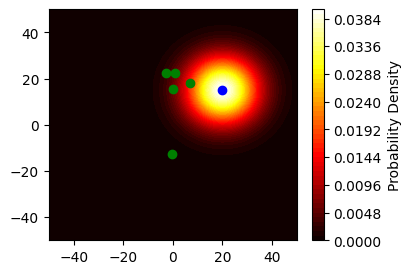

Starting Run number 32
Swarm is currently at [[  6.72595964  18.14413962  35.        ]
 [ -0.09528263  15.65067166  35.        ]
 [ -2.95898698  22.23641882  35.        ]
 [ -0.20516432 -12.56423019  35.        ]
 [  0.71091477  22.31774748  35.        ]]
A solution saw the target!
[20.117252389091874, 15.250243568955085]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.694453E+02 | -1.150502E+03
A solution saw the target!
[20.049971577294357, 15.27845011769702]
A solution saw the target!
[20.156944021795724, 15.194825510955678]
A solution saw the target!
[19.99747274848316, 15.271955125712463]
A solution saw the target!
[19.798477031131362, 15.186490568816707]
     2 |       20 | -5.205786E+02 | -1.150502E+03
Best Solution: 
 [[-1.59066228 -0.34377605]
 [ 0.77760063 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  5.13529736  17.80036357  35.        ]
 [  0.682318    15.30738874  35.        ]


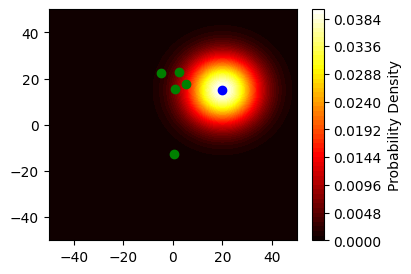

Starting Run number 33
Swarm is currently at [[  5.13529736  17.80036357  35.        ]
 [  0.682318    15.30738874  35.        ]
 [ -4.75917314  22.38000444  35.        ]
 [  0.45001426 -12.50467374  35.        ]
 [  2.48929379  22.66396764  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.589256E+01 | -6.589256E+02
A solution saw the target!
[20.104105408594066, 15.262401692315308]
A solution saw the target!
[19.749557239661748, 14.879727969323008]
A solution saw the target!
[20.07085112223205, 15.275934523220766]
     2 |       20 | -6.333671E+02 | -1.405899E+03
Best Solution: 
 [[-0.55642527  0.34445595]
 [-0.21599332  1.74677153]
 [-0.23685846 -1.54793973]
 [ 1.88396659 -1.24222941]
 [-1.14378105 -1.06885021]]
Sending swarm to 
 [[  4.57887209  18.14481953  35.        ]
 [  0.46632467  17.05416027  35.        ]
 [ -4.99603161  20.83206471  35.        ]
 [  2.33398085 -13.74690315  35.        ]
 [  1.34551274  21.59511744  35.        ]]
Target S

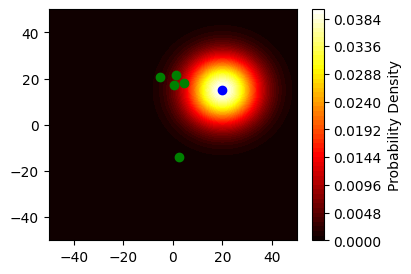

Starting Run number 34
Swarm is currently at [[  4.57887209  18.14481953  35.        ]
 [  0.46632467  17.05416027  35.        ]
 [ -4.99603161  20.83206471  35.        ]
 [  2.33398085 -13.74690315  35.        ]
 [  1.34551274  21.59511744  35.        ]]
A solution saw the target!
[20.05770414173424, 14.945925494360203]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.382148E+01 | -4.258447E+02
A solution saw the target!
[20.185210142011, 15.22433964644261]
A solution saw the target!
[19.922446473291533, 15.195505417191526]
A solution saw the target!
[20.209246200947618, 15.208882031809932]
     2 |       20 | -3.082291E+02 | -7.680827E+02
Best Solution: 
 [[-0.37162892 -0.83208849]
 [-1.21718082 -1.31614281]
 [-1.66651164 -0.67426346]
 [-1.84853824 -0.80588629]
 [ 1.00324841  0.05737934]]
Sending swarm to 
 [[  4.20724317  17.31273104  35.        ]
 [ -0.75085615  15.73801746  35.        ]
 [ -6.66254325  20.15780125  35.        ]
 [  0.48544262 -14.55278944  

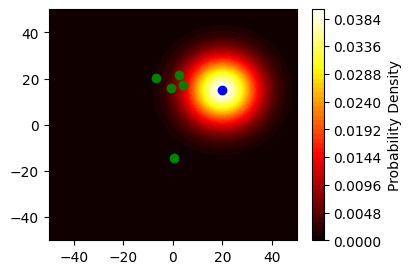

Starting Run number 35
Swarm is currently at [[  4.20724317  17.31273104  35.        ]
 [ -0.75085615  15.73801746  35.        ]
 [ -6.66254325  20.15780125  35.        ]
 [  0.48544262 -14.55278944  35.        ]
 [  2.34876115  21.65249678  35.        ]]
A solution saw the target!
[19.746625210264174, 15.113392925034477]
A solution saw the target!
[20.101522858362927, 15.225099851577593]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.820940E+02 | -1.103884E+03
A solution saw the target!
[19.99708855186872, 15.255958926057449]
A solution saw the target!
[19.746625210264174, 15.113392925034477]
     2 |       20 | -6.201445E+02 | -1.103884E+03
Best Solution: 
 [[-1.59066228 -0.34377605]
 [ 0.77760063 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[ 2.61658088e+00  1.69689550e+01  3.50000000e+01]
 [ 2.67444821e-02  1.53947345e+01  3.50000000e+01]
 [-8.46272941e+00  2.03013869e+01  3.50000000e+01

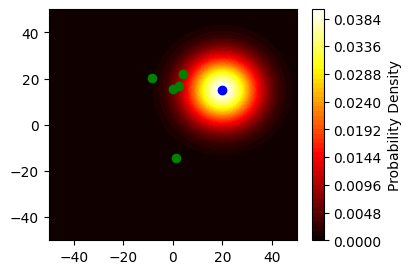

Starting Run number 36
Swarm is currently at [[ 2.61658088e+00  1.69689550e+01  3.50000000e+01]
 [ 2.67444821e-02  1.53947345e+01  3.50000000e+01]
 [-8.46272941e+00  2.03013869e+01  3.50000000e+01]
 [ 1.14062120e+00 -1.44932330e+01  3.50000000e+01]
 [ 4.12714018e+00  2.19987169e+01  3.50000000e+01]]
A solution saw the target!
[20.012821191376208, 15.016821282229571]
A solution saw the target!
[20.064004270777872, 15.283991599362157]
A solution saw the target!
[20.10384735787731, 15.08363736331928]
A solution saw the target!
[20.1046855771337, 15.26384180368614]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.198565E+02 | -1.194749E+03
A solution saw the target!
[19.785082357185416, 15.190334820443116]
     2 |       20 | -6.493084E+02 | -1.254077E+03
Best Solution: 
 [[ 1.98519436  1.96213802]
 [ 0.15075149  1.91382308]
 [-0.03370736  1.79496986]
 [ 1.3262864  -1.98875624]
 [ 0.35722215  0.2044479 ]]
Sending swarm to 
 [[  4.60177524  18.93109301  35.        ]


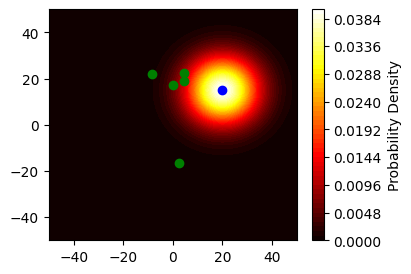

Starting Run number 37
Swarm is currently at [[  4.60177524  18.93109301  35.        ]
 [  0.17749597  17.30855762  35.        ]
 [ -8.49643678  22.09635674  35.        ]
 [  2.4669076  -16.48198923  35.        ]
 [  4.48436232  22.20316484  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.302856E+02 | -7.540727E+02
A solution saw the target!
[20.2718662983603, 15.054318120451997]
     2 |       20 | -5.769203E+02 | -1.100687E+03
Best Solution: 
 [[-0.33191198 -0.62537188]
 [-1.68568441  0.37318555]
 [-1.05026531 -1.96036943]
 [ 1.35040769 -1.83120356]
 [ 1.80520535  0.74275689]]
Sending swarm to 
 [[  4.26986326  18.30572113  35.        ]
 [ -1.50818844  17.68174317  35.        ]
 [ -9.54670208  20.1359873   35.        ]
 [  3.81731529 -18.31319278  35.        ]
 [  6.28956768  22.94592172  35.        ]]


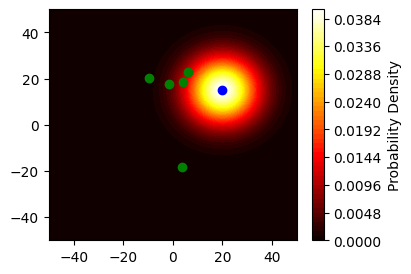

Starting Run number 38
Swarm is currently at [[  4.26986326  18.30572113  35.        ]
 [ -1.50818844  17.68174317  35.        ]
 [ -9.54670208  20.1359873   35.        ]
 [  3.81731529 -18.31319278  35.        ]
 [  6.28956768  22.94592172  35.        ]]
A solution saw the target!
[20.131213317585733, 14.91556809200657]
A solution saw the target!
[20.215588466173436, 15.044262663119415]
A solution saw the target!
[20.289931855669415, 15.010794142435508]
A solution saw the target!
[20.11726372856006, 15.259263865881918]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.176478E+02 | -1.172605E+03
A solution saw the target!
[19.825325058373622, 15.209529588550188]
A solution saw the target!
[19.85235049467004, 15.17171508594259]
A solution saw the target!
[20.11726372856006, 15.259263865881918]
     2 |       20 | -6.813089E+02 | -1.172605E+03
Best Solution: 
 [[-1.59066228 -0.34377605]
 [ 0.77760063 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645

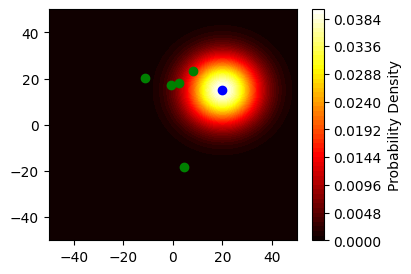

Starting Run number 39
Swarm is currently at [[  2.67920098  17.96194508  35.        ]
 [ -0.73058781  17.33846025  35.        ]
 [-11.34688825  20.27957293  35.        ]
 [  4.47249387 -18.25363634  35.        ]
 [  8.0679467   23.29214188  35.        ]]
A solution saw the target!
[20.230512842364945, 15.048534123032594]
A solution saw the target!
[19.84545213833711, 15.015701804792908]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.051210E+02 | -1.476998E+03
A solution saw the target!
[20.08137748598533, 15.288543875825747]
     2 |       20 | -5.047089E+02 | -1.476998E+03
Best Solution: 
 [[-1.60661266 -0.3155695 ]
 [ 1.83155812  0.13266114]
 [ 0.76750846 -0.73793748]
 [ 0.74600371  1.33850269]
 [-1.92684689  1.00057726]]
Sending swarm to 
 [[  1.07258831  17.64637558  35.        ]
 [  1.10097031  17.47112139  35.        ]
 [-10.57937979  19.54163545  35.        ]
 [  5.21849758 -16.91513365  35.        ]
 [  6.14109981  24.29271914  35.        ]]


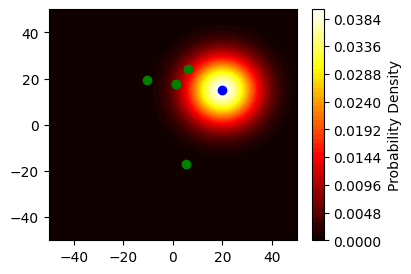

Starting Run number 40
Swarm is currently at [[  1.07258831  17.64637558  35.        ]
 [  1.10097031  17.47112139  35.        ]
 [-10.57937979  19.54163545  35.        ]
 [  5.21849758 -16.91513365  35.        ]
 [  6.14109981  24.29271914  35.        ]]
A solution saw the target!
[20.03254886203846, 15.139742284487049]
A solution saw the target!
[20.27746625283389, 14.996231062358719]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.896285E+02 | -1.238905E+03
A solution saw the target!
[20.21371325269551, 14.914654464650946]
A solution saw the target!
[20.03254886203846, 15.139742284487049]
     2 |       20 | -6.631501E+02 | -1.395488E+03
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  2.60581268  17.30259953  35.        ]
 [  2.10474005  17.12783847  35.        ]
 [-12.37956596  19.68522108  35.        ]
 [  5.87367616 -16.8555772  

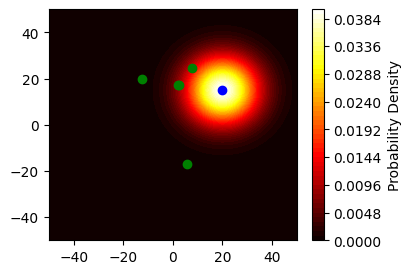

Starting Run number 41
Swarm is currently at [[  2.60581268  17.30259953  35.        ]
 [  2.10474005  17.12783847  35.        ]
 [-12.37956596  19.68522108  35.        ]
 [  5.87367616 -16.8555772   35.        ]
 [  7.91947884  24.63893931  35.        ]]
A solution saw the target!
[20.050683543202688, 14.994734294606856]
A solution saw the target!
[20.193313202494327, 15.15665060077069]
A solution saw the target!
[20.01574927236902, 14.959933223536417]
A solution saw the target!
[20.112537852066843, 15.052748164078126]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.911576E+02 | -1.411876E+03
A solution saw the target!
[20.124168619740487, 14.914010293877363]
A solution saw the target!
[20.050683543202688, 14.994734294606856]
A solution saw the target!
[19.834584881711976, 15.103444445664747]
     2 |       20 | -7.327081E+02 | -1.411876E+03
Best Solution: 
 [[ 1.20297827  1.8730463 ]
 [-0.74630329  0.76929046]
 [ 1.50555661  1.57842665]
 [-1.65982315 -1.84378

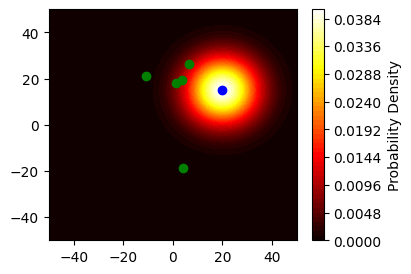

Starting Run number 42
Swarm is currently at [[  3.80879095  19.17564583  35.        ]
 [  1.35843676  17.89712893  35.        ]
 [-10.87400935  21.26364773  35.        ]
 [  4.213853   -18.69935807  35.        ]
 [  6.59880051  26.15150932  35.        ]]
A solution saw the target!
[19.966820899208628, 14.853661585985918]
A solution saw the target!
[19.961634689847177, 14.773719732476522]
A solution saw the target!
[20.14934164691315, 15.239177644151841]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.227428E+02 | -1.310621E+03
A solution saw the target!
[19.87769935016972, 14.751677775385698]
     2 |       20 | -8.571927E+02 | -1.328138E+03
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  5.34201532  18.83186978  35.        ]
 [  2.3622065   17.55384601  35.        ]
 [-12.67419551  21.40723335  35.        ]
 [  4.86903158 -18.6398016

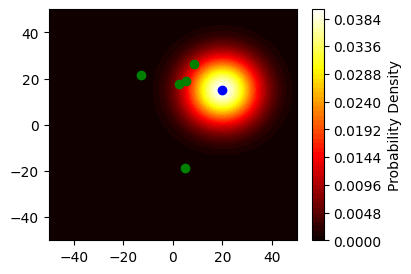

Starting Run number 43
Swarm is currently at [[  5.34201532  18.83186978  35.        ]
 [  2.3622065   17.55384601  35.        ]
 [-12.67419551  21.40723335  35.        ]
 [  4.86903158 -18.63980162  35.        ]
 [  8.37717954  26.49772948  35.        ]]
A solution saw the target!
[20.132014650548754, 15.263893140863665]
A solution saw the target!
[19.944615069078868, 14.854172727632623]
A solution saw the target!
[20.09093197376028, 15.097392395525814]
A solution saw the target!
[19.996461553042966, 14.998948335652388]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.017470E+02 | -1.373695E+03
A solution saw the target!
[20.075025339355278, 15.263034714504997]
A solution saw the target!
[20.15487835032024, 14.770836836884545]
A solution saw the target!
[19.85451692674575, 14.991180433164658]
A solution saw the target!
[20.09093197376028, 15.270827798371556]
A solution saw the target!
[19.72898651311322, 14.973387249764809]
     2 |       20 | -9.549112E+02 | -

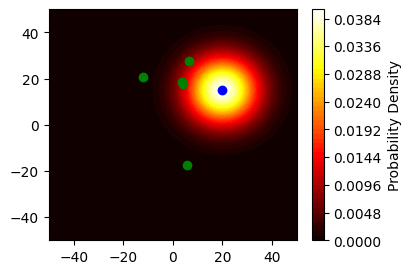

Starting Run number 44
Swarm is currently at [[  3.73540265  18.51630028  35.        ]
 [  4.19376462  17.68650715  35.        ]
 [-11.90668706  20.66929588  35.        ]
 [  5.6150353  -17.30129893  35.        ]
 [  6.45033265  27.49830674  35.        ]]
A solution saw the target!
[20.20672379076273, 15.17450697146969]
A solution saw the target!
[20.19568482401747, 15.164222152188682]
A solution saw the target!
[20.075953347068587, 15.281115096972488]
A solution saw the target!
[19.762533988680328, 14.89752136672623]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.911369E+02 | -9.528211E+02
A solution saw the target!
[19.858584026998436, 15.171698597888225]
A solution saw the target!
[19.993835434244737, 15.287010723986088]
A solution saw the target!
[20.111609358122074, 15.112722724162063]
A solution saw the target!
[20.24677441640733, 15.167077518119845]
A solution saw the target!
[20.16277804098952, 15.184468171175588]
A solution saw the target!
[20.0922500

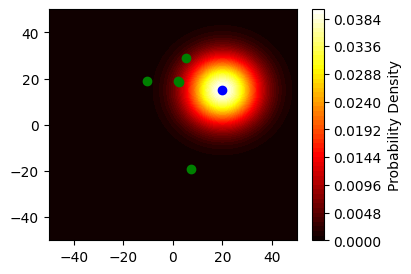

Starting Run number 45
Swarm is currently at [[  2.25869318  18.75842531  35.        ]
 [  2.38721627  18.45579761  35.        ]
 [-10.40113045  18.88329269  35.        ]
 [  7.28775128 -18.98121838  35.        ]
 [  5.12965433  29.01087675  35.        ]]
A solution saw the target!
[19.938485038871168, 14.96771473428187]
A solution saw the target!
[19.977398377933966, 15.267683885754899]
A solution saw the target!
[20.28606876886777, 15.060419663488188]
A solution saw the target!
[20.191598348150457, 15.1532346040299]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.046370E+02 | -1.214080E+03
A solution saw the target!
[19.884464115132207, 15.26950873438265]
A solution saw the target!
[19.938485038871168, 14.96771473428187]
A solution saw the target!
[20.031056768314258, 15.170102066195552]
     2 |       20 | -7.644683E+02 | -1.262344E+03
Best Solution: 
 [[-0.37162892 -0.83208849]
 [-1.21718082 -1.31614281]
 [-1.66651164 -0.67426346]
 [-1.84853824 -0.80588629]

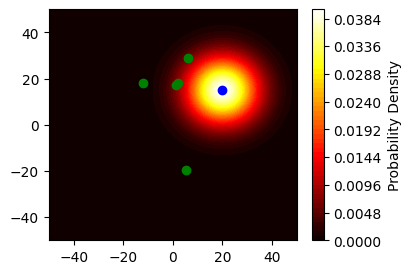

Starting Run number 46
Swarm is currently at [[  1.88706426  17.92633682  35.        ]
 [  1.17003544  17.1396548   35.        ]
 [-12.06764209  18.20902923  35.        ]
 [  5.43921304 -19.78710467  35.        ]
 [  6.13290274  29.0682561   35.        ]]
A solution saw the target!
[20.17479875848102, 15.14686094592501]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.634277E+02 | -1.310973E+03
A solution saw the target!
[20.114931119046737, 15.275328950456656]
A solution saw the target!
[19.79417944892497, 15.216353076730496]
A solution saw the target!
[19.759438554512887, 15.110008447572303]
A solution saw the target!
[20.13326691537388, 15.247043961604193]
A solution saw the target!
[19.89684578812615, 15.13380422737325]
     2 |       20 | -7.666846E+02 | -1.358507E+03
Best Solution: 
 [[ 1.98519436  1.96213802]
 [ 0.15075149  1.91382308]
 [-0.03370736  1.79496986]
 [ 1.3262864  -1.98875624]
 [ 0.35722215  0.2044479 ]]
Sending swarm to 
 [[  3.87225862  19.8

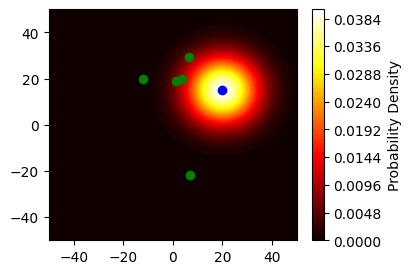

Starting Run number 47
Swarm is currently at [[  3.87225862  19.88847483  35.        ]
 [  1.32078693  19.05347788  35.        ]
 [-12.10134945  20.00399909  35.        ]
 [  6.76549944 -21.77586091  35.        ]
 [  6.49012489  29.27270399  35.        ]]
A solution saw the target!
[20.215154596676488, 14.910776971308863]
A solution saw the target!
[19.95824390484875, 15.223802841333649]
A solution saw the target!
[19.738573226957985, 15.141846614841679]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.359078E+02 | -1.433126E+03
A solution saw the target!
[20.025882265691227, 15.288517845726918]
A solution saw the target!
[20.044218062018366, 15.196479856736076]
A solution saw the target!
[19.861455325150928, 15.240670303499304]
A solution saw the target!
[19.807796934770636, 15.210746122781892]
A solution saw the target!
[19.882027865334145, 15.261994755584448]
     2 |       20 | -8.085778E+02 | -1.447603E+03
Best Solution: 
 [[-0.55642527  0.34445595]
 [-0.21

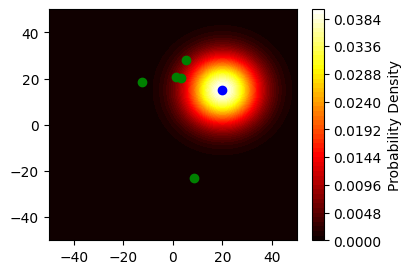

Starting Run number 48
Swarm is currently at [[  3.31583336  20.23293079  35.        ]
 [  1.10479361  20.80024941  35.        ]
 [-12.33820791  18.45605936  35.        ]
 [  8.64946603 -23.01809032  35.        ]
 [  5.34634383  28.20385378  35.        ]]
A solution saw the target!
[19.83640954635999, 15.244492765981013]
A solution saw the target!
[20.23925001294728, 15.104733193592493]
A solution saw the target!
[20.056487276079842, 15.018432694495438]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.446411E+02 | -9.598053E+02
A solution saw the target!
[20.09340821634338, 15.239715639568795]
A solution saw the target!
[19.83640954635999, 15.244492765981013]
A solution saw the target!
[20.11174401267052, 15.211430650716332]
A solution saw the target!
[20.066581885837927, 15.225696916762146]
A solution saw the target!
[19.758294815571162, 14.89442754873443]
     2 |       20 | -5.924821E+02 | -1.029957E+03
Best Solution: 
 [[-0.55642527  0.34445595]
 [-0.2159933

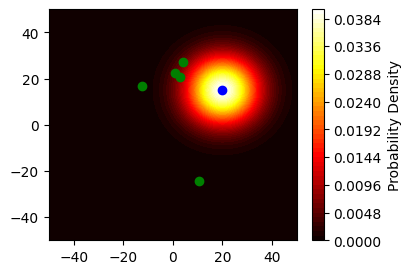

Starting Run number 49
Swarm is currently at [[  2.75940809  20.57738674  35.        ]
 [  0.88880028  22.54702094  35.        ]
 [-12.57506638  16.90811963  35.        ]
 [ 10.53343263 -24.26031973  35.        ]
 [  4.20256278  27.13500358  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.568913E+02 | -4.547443E+02
A solution saw the target!
[19.90592216644202, 15.127160433272293]
A solution saw the target!
[19.942848836074948, 15.240647710742401]
     2 |       20 | -4.276283E+02 | -9.752658E+02
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[  4.29263245  20.2336107   35.        ]
 [  1.89257002  22.20373802  35.        ]
 [-14.37525254  17.05170526  35.        ]
 [ 11.18861121 -24.20076328  35.        ]
 [  5.98094181  27.48122374  35.        ]]


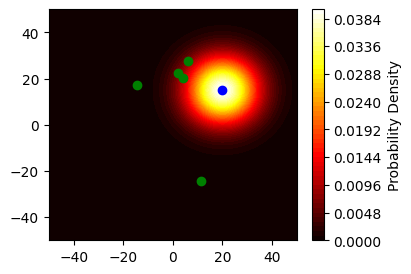

Starting Run number 50
Swarm is currently at [[  4.29263245  20.2336107   35.        ]
 [  1.89257002  22.20373802  35.        ]
 [-14.37525254  17.05170526  35.        ]
 [ 11.18861121 -24.20076328  35.        ]
 [  5.98094181  27.48122374  35.        ]]
A solution saw the target!
[19.928591949603074, 14.902411967616318]
A solution saw the target!
[19.853799982719433, 15.210892149027204]
A solution saw the target!
[19.95908482596495, 15.281159590610237]
A solution saw the target!
[19.866920148350946, 14.880438363426373]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.658127E+02 | -1.331967E+03
A solution saw the target!
[19.962970186669047, 15.15461559458837]
A solution saw the target!
[20.16197459405373, 15.206174720547851]
A solution saw the target!
[19.853799982719433, 15.190083605874285]
A solution saw the target!
[19.915269848021794, 14.789594635988635]
     2 |       20 | -8.728341E+02 | -1.338544E+03
Best Solution: 
 [[-1.6709193   1.24026251]
 [ 1.9020

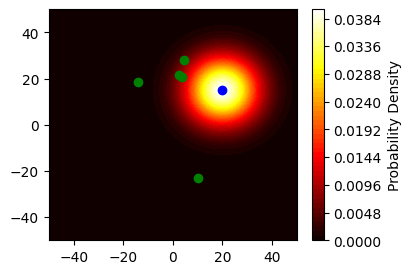

Starting Run number 51
Swarm is currently at [[  2.62171315  21.47387321  35.        ]
 [  3.79464483  20.86922173  35.        ]
 [-14.01654071  18.65147025  35.        ]
 [ 10.33647927 -22.8424289   35.        ]
 [  4.54248956  28.14803375  35.        ]]
A solution saw the target!
[20.00538354000005, 14.943681806301525]
A solution saw the target!
[20.009172740559837, 15.112666158694276]
A solution saw the target!
[20.027763613865623, 15.297382882002308]
A solution saw the target!
[19.953916003969155, 15.217624660012357]
A solution saw the target!
[19.986951583528597, 15.11918060013893]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -9.783959E+02 | -1.517295E+03
A solution saw the target!
[20.054589944371074, 15.12014260439382]
A solution saw the target!
[20.072925740698214, 15.219363615818114]
A solution saw the target!
[20.027763613865623, 15.297382882002308]
A solution saw the target!
[19.83566654113121, 14.901880241560924]
     2 |       20 | -1.242968E+03 | 

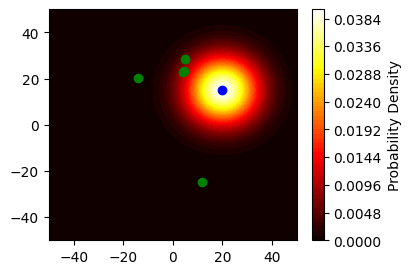

Starting Run number 52
Swarm is currently at [[  4.60690751  23.43601122  35.        ]
 [  3.94539632  22.78304481  35.        ]
 [-14.05024807  20.44644011  35.        ]
 [ 11.66276566 -24.83118514  35.        ]
 [  4.89971171  28.35248164  35.        ]]
A solution saw the target!
[19.718274497431587, 15.095570574510067]
A solution saw the target!
[19.79780409628902, 14.950784906920418]
A solution saw the target!
[20.04762988748108, 15.189608054102916]
A solution saw the target!
[20.002467760648486, 15.183065776995813]
A solution saw the target!
[20.056126151028778, 15.16706055514424]
A solution saw the target!
[19.961655730311463, 15.19612249554757]
A solution saw the target!
[19.747047886473275, 14.936219246651257]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -6.791196E+02 | -1.130788E+03
A solution saw the target!
[20.093047091292316, 15.26083749994084]
A solution saw the target!
[19.7433941177202, 14.97211616732756]
A solution saw the target!
[20.238888887

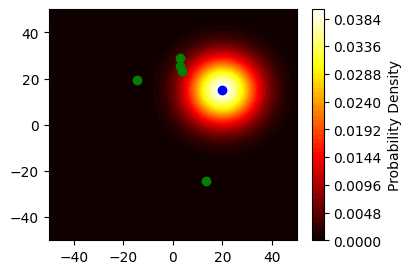

Starting Run number 53
Swarm is currently at [[  3.06589141  25.23396826  35.        ]
 [  3.74504485  23.09660326  35.        ]
 [-14.41770086  19.39454803  35.        ]
 [ 13.27628375 -24.53646719  35.        ]
 [  2.91119302  28.8210613   35.        ]]


In [ ]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
#waypoints=np.array([[-5,0,35.],[-2,0,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
#swarm.waypoints(ids,waypoints)

visibility_grid= "Null"
runNumber=0

#print(f"Starting with waypoints: \n {waypoints}")

sigma=10



while not finished:
    #wait until all drones received
    if swarm.received_frames[ids[-1]]:
        print(f"Starting Run number {runNumber}")
        print(f"Swarm is currently at {problem.waypoints}")
        runNumber+=1
        
        #get best solution
        res = minimize(problem, algorithm, termination, seed=1, verbose=True)
        _x= np.array(res.X)*4-2
        best_solution = _x.reshape(-1, 2)
        #best_solution = res.X.reshape(-1, 2)
        print(f"Best Solution: \n {best_solution}")
        #update waypoints
        waypoints = waypoints + np.pad(best_solution,((0, 0), (0, 1)),mode='constant',constant_values=0)
        swarm.waypoints(ids,waypoints)
        print(f"Sending swarm to \n {waypoints}")
        #update probability_grid and waypoints
        problem.waypoints = waypoints
        sigma+=1
        
        if targetSeen:
            print("Target Seen!\n Updating target Position and resetting Sigma")
            sigma = 2
            Last_Known_Position= Target_Position
            targetSeen = False
        
        problem.prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)
        
        
        
        plt.figure(figsize=(4, 3))
        plt.contourf(x, y, prob_density, levels=50, cmap='hot')
        plt.colorbar(label='Probability Density')
        plt.scatter(Last_Known_Position[0],Last_Known_Position[1], color='blue', label='Last Known Position')
        plt.scatter(waypoints[:, 0],waypoints[:, 1], color='green', label='Drones')
        plt.show()
